<h1>Estimación del crédito bancario al sector privado</h1>

En este documento se hace la estimacion mensual del crédito bancario al sector privado de acuerdo con el documento de análisis que se encuentra en la misma carpeta. Este análisis utiliza los modelos de series de tiempo, en particular el modelo SARIMAX para capturar esta relacion.

Las series de tiempo se obtienen por medio de la API Banco de México con el propósito de que se puedan obtener y ajustar la estimación rápidamente ante la actualización de estas series.

In [2]:
from pathlib import Path
import os

os.chdir('C:/ABM/Analisis/Credito_PIB/arquitectura_modelos')

# Buscar el primer directorio padre que contenga un archivo específico
def find_project_root(filename="requirements.txt"):
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / filename).exists():
            return parent
    raise FileNotFoundError(f"No se encontró {filename} en ningún directorio padre.")

# Establecer como root
os.chdir(find_project_root())
print("Nuevo directorio:", os.getcwd())

Nuevo directorio: C:\ABM\Analisis\Credito_PIB


In [ ]:
# Importar librerias 

import os
import pandas as pd
import numpy as np

import random

from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.frequencies import to_offset

from dotenv import load_dotenv

from api_caller.banxico import Banxico_SIE

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Pytorch para redes neuroanles
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# Importamos modulos propios
from procesamiento_datos import descarga_series_principales
from arquitectura_modelos import MultivariateTimeSeriesDataset, Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster
from arquitectura_modelos.set_seed import set_seed


# Evitamos mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

# Lectura de series

In [4]:
# Descargamos las series principales
series = descarga_series_principales({'SL11453':'Rem_manufactura', 'SL11426':'Rem_comercio'})
series.index.freq = 'MS'  # Establecemos la frecuencia mensual


# Procesamiento

In [5]:
# Quitamos lo nan del inicio del dataframe
series = series[series.dropna().index.min():]

In [6]:
print(series)

            Rem_comercio  Rem_manufactura
2008-01-01       55.4631          58.2025
2008-02-01       54.9351          58.0487
2008-03-01       56.6896          60.0496
2008-04-01       56.1591          63.7500
2008-05-01       65.8012          72.5806
...                  ...              ...
2024-12-01      210.5768         196.0533
2025-01-01      178.5238         155.3590
2025-02-01      175.5329         153.7137
2025-03-01      178.9766         159.6086
2025-04-01      181.4176         166.1227

[208 rows x 2 columns]


# Preparacion para entrenamiento

In [7]:
# Separamos las series objetivo y exógenas
series_objetivo = ['Rem_comercio', 'Rem_manufactura']
series_exogenas = []
series_input = series_objetivo + series_exogenas

# Definimos variables de cambio de tendencia a partir de fecha designada (shock)
shock_dict = None

In [8]:
# Definimos el periodo de entrenamiento
rezago_anos = 2

last_date = series.dropna().index.max()
train_date = last_date + relativedelta(months=-12*rezago_anos)
validation_date = last_date + relativedelta(months=-12*(rezago_anos-1)//2)

# Separamos los datos de entrenamiento y validacion para el modelo de Seq2seq
df = series.copy()
df_train = df.loc[:train_date, series_input]
df_val = df.loc[(validation_date + relativedelta(months=-12*8)):validation_date, series_input]
df_test = df.loc[:last_date, series_input]

print(f"Datos de entrenamiento hasta el: {train_date.strftime('%Y-%m')}")
print(f"Datos de validacion hasta el: {validation_date.strftime('%Y-%m')}")
print(f"Datos de prueba hasta el: {last_date.strftime('%Y-%m')}")


Datos de entrenamiento hasta el: 2023-04
Datos de validacion hasta el: 2024-10
Datos de prueba hasta el: 2025-04


In [9]:
print(df_train)

            Rem_comercio  Rem_manufactura
2008-01-01       55.4631          58.2025
2008-02-01       54.9351          58.0487
2008-03-01       56.6896          60.0496
2008-04-01       56.1591          63.7500
2008-05-01       65.8012          72.5806
...                  ...              ...
2022-12-01      169.9357         167.5151
2023-01-01      142.6320         127.5046
2023-02-01      143.0225         128.5986
2023-03-01      148.8250         140.0832
2023-04-01      149.3040         136.7262

[184 rows x 2 columns]


In [10]:
# Funcion para definir semilla
def set_seed(seed: int = 21):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# Parametros

In [11]:
# Parametros
hist_len = 12*4
horizon = 12*2
batch_size = 10

lag = hist_len

len_shock_dict = len(shock_dict) if shock_dict is not None else 0
len_lag = 1 if lag else 0

input_size = len(series_exogenas) + 1 + len_shock_dict + 4 + len_lag # Exogenas + time features + lag
output_size = 1

hidden_size = 128
num_layers = 2
ca_size = hidden_size
ct_size = hidden_size // 2
min_hist_len = 3

quantiles = [0.05, 0.5, 0.95]
learning_rate = 1e-3

num_embeddings = len(series_objetivo)
embedding_dim = 4*num_embeddings

set_seed()

In [12]:
# Dataset de entrenamiento
train_dataset = MultivariateTimeSeriesDataset(
    df = df_train,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    lag = lag,
)

# DataLoader en entrenamiento
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset de validación
val_dataset = MultivariateTimeSeriesDataset(
    df = df_val,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    mean = train_dataset.mean,
    std = train_dataset.std,
    lag = train_dataset.lag,
)

# DataLoader en validación
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Verificacion del shape de val_dataloader
for x_hist, x_fut, y_hist, y_fut, series_idx in iter(train_dataloader):
    print('\nShapes of the training batch:')
    print(f'x_hist: {x_hist.shape}')
    print(f'x_fut: {x_fut.shape}')
    print(f'y_hist: {y_hist.shape}')
    print(f'y_fut: {y_fut.shape}')
    print(f'series_idx: {series_idx}')
    break
    


Shapes of the training batch:
x_hist: torch.Size([10, 48, 5])
x_fut: torch.Size([10, 24, 5])
y_hist: torch.Size([10, 48, 1])
y_fut: torch.Size([10, 24, 1])
series_idx: tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1])


# Entrenamiento

In [14]:
# Modelo
model = Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster(hist_len = hist_len,
                horizon = horizon,
                input_size = input_size,
                output_size = output_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                ct_size = ct_size,
                ca_size = ca_size,
                min_hist_len = min_hist_len,
                quantiles = quantiles,
                learning_rate = learning_rate,
                num_embeddings = num_embeddings,
                embedding_dim = embedding_dim)

model.target_cols = series_objetivo
model.exog_cols = series_exogenas
model.mean = train_dataset.mean
model.std = train_dataset.std
model.shock_dict = train_dataset.shock_dict
model.series_id_map = train_dataset.series_id_map
model.lag = train_dataset.lag


In [15]:
# Verificacion de que el modelo funciona
batch = next(iter(train_dataloader))

x_hist, x_fut, y_hist, y_fut, series_idx = batch
y_hat, _, _ = model.forward(x_hist, x_fut, y_hist, series_idx)

# Vemos si hay nan
print("Shape de y_hat:", y_hat.shape)
print("Hay NaN en y_hat:", torch.isnan(y_hat).any().item())

Shape de y_hat: torch.Size([10, 24, 1, 3])
Hay NaN en y_hat: False


In [16]:
# Entrenamiento
epochs = 20

trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, train_dataloader, val_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | series_embedding | Embedding  | 16     | train
1 | encoder          | LSTM       | 205 K  | train
2 | global_mlp       | Sequential | 422 K  | train
3 | local_mlp        | Sequential | 41.8 K | train
--------------------------------------------------------
670 K     Trainable params
0         Non-trainable params
670 K     Total params
2.681     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s, v_num=363, train_loss_step=0.0143, val_QL=0.192, train_loss_epoch=0.0114] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s, v_num=363, train_loss_step=0.0143, val_QL=0.192, train_loss_epoch=0.0114]


# Validacion

In [17]:
# Predicciones
initial_pred_date = pd.to_datetime("2024-04-01")
#initial_pred_date = validation_date + relativedelta(months=1)  # Ajustamos la fecha de inicio de predicción
end_year_pred = datetime(initial_pred_date.year, 12, 1)
end_year_1_pred = datetime(initial_pred_date.year + 1, 12, 1)

target_col = series_objetivo[0]

predicciones = model.predict(
    df = df,
    target_col = target_col,
    initial_pred_date = initial_pred_date
)

# Concatenar los dataframes
df_combined = pd.concat([df[series_input], predicciones], axis=1)

# Acotar el DataFrame a las fechas de interés
df_combined = df_combined.loc[initial_pred_date + relativedelta(months=-12*4):(initial_pred_date + relativedelta(months=30))]

Predicción para Rem_comercio desde 2024-04-01 00:00:00 hasta 2026-03-01 00:00:00
Ventana de historia: 2020-04-01 00:00:00 - 2024-03-01 00:00:00


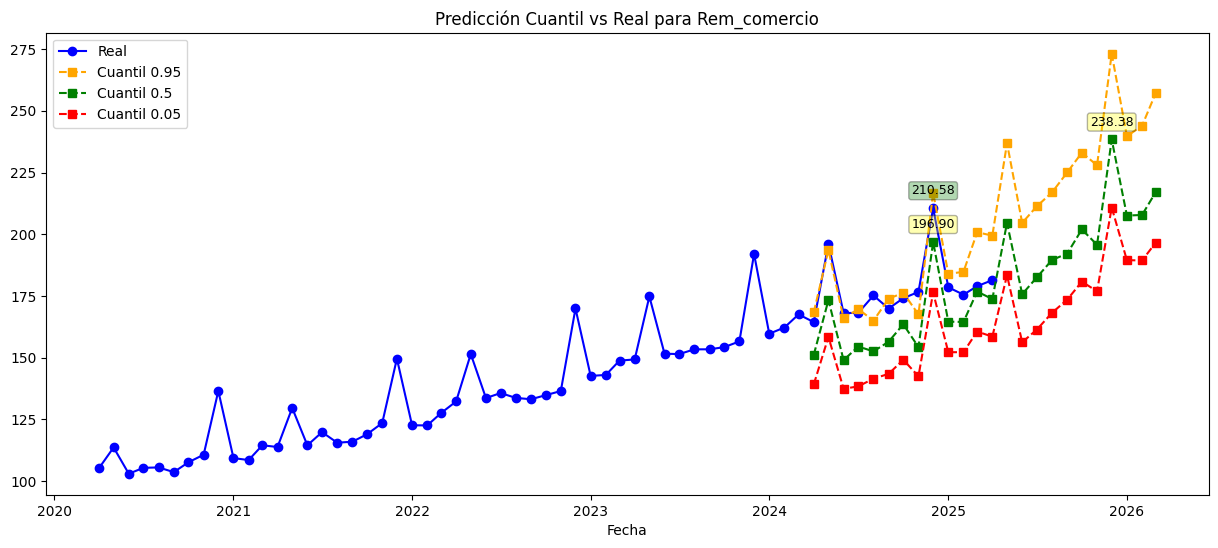

In [18]:
# Iterar sobre cada variable objetivo para crear una gráfica
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la serie real
plt.plot(df_combined.index, df_combined[target_col], label='Real', marker='o', linestyle='-', color='blue')
#plt.plot(df_combined.index, df_combined['pron_pib'], label='PIB', linestyle='-', color='gray')

if end_year_pred in df_combined.index:
    valor = df_combined.at[end_year_pred, target_col]
    ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
    
if end_year_1_pred in df_combined.index:
    valor = df_combined.at[end_year_1_pred, target_col]
    ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))


for quantile, color in zip(quantiles[::-1], ['orange', 'green', 'red']):
    col_name = f'{target_col}_{int(quantile*100)}'
    if col_name in df_combined.columns:
        plt.plot(df_combined.index, df_combined[col_name], label=f'Cuantil {quantile}', marker='s', linestyle='--', color=color)
        
        if col_name == f'{target_col}_50':
            if end_year_pred in df_combined.index:
                valor = df_combined.at[end_year_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
                
            if end_year_1_pred in df_combined.index:
                valor = df_combined.at[end_year_1_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))

plt.xlabel('Fecha')

plt.title(f'Predicción Cuantil vs Real para {target_col}')
plt.legend()
plt.show()


# Guardar Modelo

In [19]:
# Guardar el modelo y sus atributos
model_path = "modelos\seq2seq_Rem_nom.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'horizon': model.horizon,
    'hist_len': model.hist_len,
    'input_size': model.input_size,
    'output_size': model.output_size,
    'hidden_size': model.hidden_size,
    'num_layers': model.num_layers,
    'ct_size': model.ct_size,
    'ca_size': model.ca_size,
    'min_hist_len': model.min_hist_len,
    'quantiles': model.quantiles,
    'learning_rate': model.learning_rate,
    'num_embeddings': model.num_embeddings,
    'embedding_dim': model.embedding_dim,
    'target_cols': model.target_cols,
    'exog_cols': model.exog_cols,
    'mean': model.mean,
    'std': model.std,
    'shock_dict': model.shock_dict,
    'series_id_map': model.series_id_map,
}, model_path)

print(f"Modelo y atributos guardados en {model_path}")

Modelo y atributos guardados en modelos\seq2seq_Rem_nom.pth
